### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
import time

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
#Time_matrix = np.load("../input/time-matrix/TM.npy")

#### Tracking the state-action pairs for checking convergence

In [4]:
# Q_dict = collections.defaultdict(dict)
# States_track = collections.defaultdict(dict)

In [5]:
# # To initialise the track states
# def initialise_tracking_states():
#     # Tracking the state action pair ((2,2,0), (0,0)). 
#     # Since the action (0,0) is at position 0, we will denote action index 0 to point to 0 action
#     sample_q_values = [("0_1_0_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_0_0_0_0_0_0", 0)]
#     for q_value in sample_q_values:
#         state = q_value[0]
#         action = q_value[1]
#         States_track[state][action] = []

# # # Saving the q values of the track states
# def save_tracking_states():
#     for state in States_track.keys():
#         for action_index in States_track[state].keys():
#             q_value = agent.model.predict(np.array(state.split("_")).reshape(1,36))
#             States_track[state][action].append(q_value[0][action_index])

In [6]:
# Saving the rewards per episode in the pickle file

def save_pickle(obj, name):
    write_start_time = time.time()
    with open(name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    write_time_taken = time.time()-write_start_time
    print("Writing the pickle file completed in " + str(write_time_taken/60) + " minutes")
        


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01     
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        self.epsilon = 1.0

        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        self.state_to_track = (2,2,0)
        self.action_index_to_track = 0
        self.state_tracking = []

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
#         epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.000001*episode)
        z = np.random.random()
        
        possible_actions_index, agent_allowable_actions = list(env.requests(state))        
        if z > self.epsilon:
            # Exploitation
            encoded_state =np.array(env.state_encod_arch1(state)).reshape(1,36)
            q_value = self.model.predict(encoded_state)    
            allowed_q_values = [q_value[0][i] for i in possible_actions_index]
            action_index = possible_actions_index[np.argmax(allowed_q_values)]
        else:
            # Exploration
            action_index = random.choice(possible_actions_index)            
        return action_index
        
        
        
        


    def append_sample(self, state, action_index, reward, next_state, terminal_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, terminal_state))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                
                actions.append(action_index)
                rewards.append(reward)
                done.append(terminal_state)
                
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)   

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])  
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        save_start_time = time.time()
        self.model.save(name)
        save_time_taken = time.time() - save_start_time
        print("Saving the model completed in " + str(save_time_taken/60) + " minu")

    # # Saving the q values of the track states
    def save_tracking_states(self):
        q_value = agent.model.predict(np.array(env.state_encod_arch1(self.state_to_track)).reshape(1,36))
        self.state_tracking.append(q_value[0][self.action_index_to_track])                                

In [8]:
Episodes = 15000
write_threshold = 3000

### DQN block

In [11]:
start_time = time.time()

state_size = 36
action_size = 21

agent = DQNAgent(state_size, action_size)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    score = 0
    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    (action_space, state_space, state) = env.reset()
    terminal_state = False

    #Call the DQN agent
    
    count = 0
    while not terminal_state:
        
        # Write your code here
        count+=1
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index = agent.get_action(state, episode)
        action = action_space[action_index]
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_matrix)
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix) 
        # 3. Append the experience to the memory
        agent.append_sample(state, action_index, reward, next_state, terminal_state)
        # 4. Train the model by calling function agent.train_model
        if (episode%100 ==0):
            agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
    
    # Store total rewards obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
#         agent.epsilon *= agent.epsilon_decay
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)
    
    # Logging every episode
#     print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, score, len(agent.memory), agent.epsilon))
    
    # Initialising the State_track dictionary to track the state
#     if (episode == track_threshold-1):
#         initialise_tracking_states()

    if (episode%500 ==0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, score, len(agent.memory), agent.epsilon))        
    
    if (episode%10 ==0):
        agent.save_tracking_states()

    # Every few episodes
    if episode%write_threshold == 0:
        # Saving the models
        agent.save("model_weights.h5")
        # Saving the rewards per episode as a pickle file
        save_pickle(rewards_per_episode,"rewards_per_episode")

##### Simulation ends ######
elapsed_time = time.time() - start_time
print(elapsed_time/3600)

episode 0, reward -146.0, memory_length 128, epsilon 1.0
Saving the model completed in 0.00018334786097208658 minu
Writing the pickle file completed in 0.0 minutes
episode 500, reward -73.0, memory_length 2000, epsilon 0.7788029950635742
episode 1000, reward 111.0, memory_length 2000, epsilon 0.6065345944060363
episode 1500, reward -65.0, memory_length 2000, epsilon 0.4723718290754873
episode 2000, reward 207.0, memory_length 2000, epsilon 0.36788576237703063
episode 2500, reward -145.0, memory_length 2000, epsilon 0.2865119318122215
episode 3000, reward -30.0, memory_length 2000, epsilon 0.22313792884682834
Saving the model completed in 0.00023323297500610352 minu
Writing the pickle file completed in 9.919404983520508e-05 minutes
episode 3500, reward -237.0, memory_length 2000, epsilon 0.17378220571101066
episode 4000, reward -202.0, memory_length 2000, epsilon 0.13534392988378036
episode 4500, reward 262.0, memory_length 2000, epsilon 0.10540817056961871
episode 5000, reward -338.0, 

### Tracking Convergence

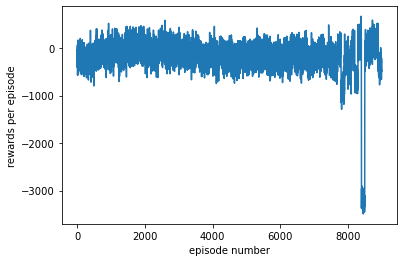

In [12]:
with open("rewards_per_episode.pkl", "rb") as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("rewards per episode")
plt.savefig('rewards.png')

In [ ]:
# import os
# os.remove("./model_weights.h5")
# os.remove("./rewards_per_episode.pkl")

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
self.epsilon_max = 1.0
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        self.epsilon = 1.0

In [ ]:
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append(0.00001 + (1 - 0.00001) * np.exp(-0.0005*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()